## Importing and setting up

In [1]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import models.tomtom_models_rewrite as tm
import models.tomtom_util as tu

Autosaving every 30 seconds


In [2]:
global tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d
global ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d
global tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d

# import pickled data
with open('../data/tomtom_data_preprocessed_withadded.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f) 

In [3]:
# # import fitted models
# with open('tomtom_fitted_models.pkl','rb') as f:
#     [seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
#      seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
#      seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
#      seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
#      seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
#      seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
#      seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
#      seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim] = pickle.load(f)

## fitting models of varying k

currently only fitting self data, swap out the target variable

In [4]:
def fit_varying_k(mtype,target,dtype,auto,maxk):
    #dynamically initiate data
    dt = globals()['t{}_{}_{}_3d'.format(target,dtype,auto)]
    seeds = []
    maps = []
    logprobs = []
    mems = []

    if 'gr' in mtype:
        for i in range(1,maxk+1):
            seed, mapp, mem, lp = tm.TransitionModel(dt, i, target, dtype, auto, mtype).fit()
            seeds.append(seed)
            maps.append(mapp)
            logprobs.append(lp)
            mems.append(mem)
        return seeds, maps, logprobs, mems
    elif 'di' in mtype:
        for i in range(1,11):
            seed, mapp, lp = tm.TransitionModel(dt, i, target, dtype, auto, mtype).fit()
            seeds.append(seed)
            maps.append(mapp)
            logprobs.append(lp)
        return seeds,maps,logprobs

In [5]:
maxk = 10
# self, normalized, with autotransitions
seeds_self_norm_all_grp, maps_self_norm_all_grp, logprobs_self_norm_all_grp, mems_self_norm_all_grp =\
    fit_varying_k('grp','self','norm','all',maxk)
seeds_self_norm_all_dim, maps_self_norm_all_dim, logprobs_self_norm_all_dim =\
    fit_varying_k('dim','self','norm','all',maxk)

running SVI with: tself_norm_all_3d
seed = 30, initial_loss = 2189.53564453125
..............................
 final loss: -23363.49609375



/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/pyro/infer/discrete.py:92: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  warnings.warn('infer_discrete found no sample sites configured for enumeration. '


running SVI with: tself_norm_all_3d
seed = 18, initial_loss = -753.21728515625
..............................
 final loss: -25853.21875

running SVI with: tself_norm_all_3d
seed = 83, initial_loss = -115.1337890625
..............................
 final loss: -26112.11328125

running SVI with: tself_norm_all_3d
seed = 7, initial_loss = 455.6276550292969
..............................
 final loss: -26764.703125

running SVI with: tself_norm_all_3d
seed = 21, initial_loss = -1311.9544677734375
..............................
 final loss: -26657.126953125

running SVI with: tself_norm_all_3d
seed = 25, initial_loss = -222.0972900390625
..............................
 final loss: -26949.3515625

running SVI with: tself_norm_all_3d
seed = 27, initial_loss = -954.42236328125
..............................
 final loss: -26910.02734375

running SVI with: tself_norm_all_3d
seed = 62, initial_loss = 235.7861328125
..............................
 final loss: -26844.482421875

running SVI with: tsel

In [6]:
# self, normalized, no autotransitions
seeds_self_norm_noauto_grp, maps_self_norm_noauto_grp, logprobs_self_norm_noauto_grp, mems_self_norm_noauto_grp =\
    fit_varying_k('grp','self','norm','noauto',maxk)
seeds_self_norm_noauto_dim, maps_self_norm_noauto_dim, logprobs_self_norm_noauto_dim =\
    fit_varying_k('dim','self','norm','noauto',maxk)

running SVI with: tself_norm_noauto_3d
seed = 14, initial_loss = 7541.52001953125
..............................
 final loss: -13065.20703125



/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/pyro/infer/discrete.py:92: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  warnings.warn('infer_discrete found no sample sites configured for enumeration. '


running SVI with: tself_norm_noauto_3d
seed = 48, initial_loss = 5303.57666015625
..............................
 final loss: -15057.5205078125

running SVI with: tself_norm_noauto_3d
seed = 63, initial_loss = 6020.810546875
..............................
 final loss: -15498.279296875

running SVI with: tself_norm_noauto_3d
seed = 40, initial_loss = 4992.0263671875
..............................
 final loss: -15716.41015625

running SVI with: tself_norm_noauto_3d
seed = 40, initial_loss = 6644.07177734375
..............................
 final loss: -15662.53125

running SVI with: tself_norm_noauto_3d
seed = 26, initial_loss = 6766.93212890625
..............................
 final loss: -15680.876953125

running SVI with: tself_norm_noauto_3d
seed = 58, initial_loss = 6636.73681640625
..............................
 final loss: -15614.5380859375

running SVI with: tself_norm_noauto_3d
seed = 12, initial_loss = 6141.21630859375
..............................
 final loss: -15680.650390625

In [7]:
# self, raw, with autotransitions
seeds_self_raw_all_grp, maps_self_raw_all_grp, logprobs_self_raw_all_grp, mems_self_raw_all_grp =\
    fit_varying_k('grp','self','raw','all',maxk)
seeds_self_raw_all_dim, maps_self_raw_all_dim, logprobs_self_raw_all_dim =\
    fit_varying_k('dim','self','raw','all',maxk)

running SVI with: tself_raw_all_3d
seed = 58, initial_loss = 88220.6875
..............................
 final loss: -3532.5908203125



/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/pyro/infer/discrete.py:92: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  warnings.warn('infer_discrete found no sample sites configured for enumeration. '


running SVI with: tself_raw_all_3d
seed = 72, initial_loss = 85132.5
..............................
 final loss: -5425.06640625

running SVI with: tself_raw_all_3d
seed = 42, initial_loss = 82557.1328125
..............................
 final loss: -6859.53759765625

running SVI with: tself_raw_all_3d
seed = 54, initial_loss = 83365.4765625
..............................
 final loss: -6542.474609375

running SVI with: tself_raw_all_3d
seed = 67, initial_loss = 82478.1328125
..............................
 final loss: -7828.6552734375

running SVI with: tself_raw_all_3d
seed = 41, initial_loss = 84080.296875
..............................
 final loss: -6664.8671875

running SVI with: tself_raw_all_3d
seed = 88, initial_loss = 81980.53125
..............................
 final loss: -7477.751953125

running SVI with: tself_raw_all_3d
seed = 47, initial_loss = 80794.78125
..............................
 final loss: -7294.98828125

running SVI with: tself_raw_all_3d
seed = 9, initial_loss = 

In [8]:
# self, raw, no autotransitions
seeds_self_raw_noauto_grp, maps_self_raw_noauto_grp, logprobs_self_raw_noauto_grp, mems_self_raw_noauto_grp =\
    fit_varying_k('grp','self','raw','noauto',maxk)
seeds_self_raw_noauto_dim, maps_self_raw_noauto_dim, logprobs_self_raw_noauto_dim =\
    fit_varying_k('dim','self','raw','noauto',maxk)

running SVI with: tself_raw_noauto_3d
seed = 73, initial_loss = 50224.46875
..............................
 final loss: -2798.165283203125



/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/pyro/infer/discrete.py:92: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  warnings.warn('infer_discrete found no sample sites configured for enumeration. '


running SVI with: tself_raw_noauto_3d
seed = 7, initial_loss = 49590.33203125
..............................
 final loss: -4322.2236328125

running SVI with: tself_raw_noauto_3d
seed = 63, initial_loss = 46113.2578125
..............................
 final loss: -4864.85400390625

running SVI with: tself_raw_noauto_3d
seed = 49, initial_loss = 48942.578125
..............................
 final loss: -5124.84765625

running SVI with: tself_raw_noauto_3d
seed = 10, initial_loss = 49137.15625
..............................
 final loss: -5127.30078125

running SVI with: tself_raw_noauto_3d
seed = 31, initial_loss = 49077.34375
..............................
 final loss: -5214.31884765625

running SVI with: tself_raw_noauto_3d
seed = 29, initial_loss = 47682.359375
..............................
 final loss: -5102.38037109375

running SVI with: tself_raw_noauto_3d
seed = 12, initial_loss = 48115.8203125
..............................
 final loss: -5023.65869140625

running SVI with: tself_ra

In [9]:
with open('tomtom_fitted_models_withadded.pkl','wb') as f:
    pickle.dump([seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
                 seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
                 seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
                 seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
                 seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
                 seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
                 seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
                 seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim],f)

## analyze fitted models

analyzing fitted raw_noauto models as an example, but could easily swap out below.

In [10]:
maps_grp = maps_self_raw_noauto_grp
maps_dim = maps_self_raw_noauto_dim
lps_grp = logprobs_self_raw_noauto_grp
lps_dim = logprobs_self_raw_noauto_dim

1) plot the models' log prob as a function of K, grouped by model type

/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

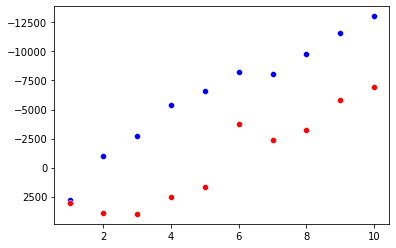

In [11]:
sns.scatterplot(range(1,11),lps_grp, color = 'blue')
sns.scatterplot(range(1,11),lps_dim, color = 'red')

2) analyze how similar grp- and dim-model parameters are as a function of K

In [12]:
# compare parameters from the two models under varying k
meancor = []
meanmaxrow = []
meanmaxcol = []
otorow = []
otocol = []
for i in range(len(maps_self_raw_noauto_grp)):
    cor_mat = tu.grp_dim_param_convergence(map_grp=maps_grp[i],map_dim=maps_dim[i], dtype='raw')
    # get the overall mean of the cormat
    meancor.append(cor_mat['b'].mean())
    # get means of row max and col max
    meanmaxrow.append(cor_mat['b'].max(1).mean())
    meanmaxcol.append(cor_mat['b'].max(0).mean())
    rowindmax, oto = tu.one_to_one_correspondence(cor_mat['b'])
    otorow.append(oto[0]) 
    otocol.append(oto[1]) 

is there evidence that there's one-to-one correspondence (indistinguishable clusters) between the group and the dimensional models?

In [13]:
print(otocol)

[True, True, False, False, False, False, False, False, False, False]


plot mean pair-wise factor parameter correlations as a function of K

alternatives: meamaxcol/meanmaxrow - mean of max parameter correlation per column/row as a function of L

/u/zidong/.conda/envs/tomtom-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Mean pair-wise param corr')

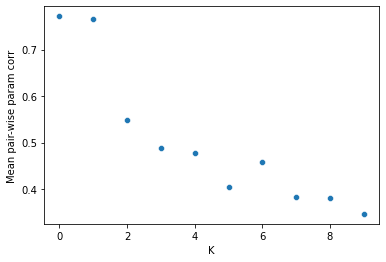

In [14]:
ax = sns.scatterplot(range(10), meancor)
ax.set_xlabel('K')
ax.set_ylabel('Mean pair-wise param corr')